# Reimplementation of Generalized distillation and its analysis (not used in the paper directly)

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST(root='../data', train=True, download=False, transform=transform)
mnist_test = datasets.MNIST(root='../data', train=False, download=False, transform=transform)

Z_train = mnist_train.data
y_train = mnist_train.targets
X_train = transforms.Resize(size=7)(mnist_train.data)
Z_train = Z_train.view(-1, 28 * 28).float() / 255.0
X_train = X_train.view(-1, 7 * 7).float() / 255.0

X_train, X_eval, Z_train, Z_eval, y_train, y_eval = train_test_split(X_train, Z_train, y_train, 
                                                                     test_size=0.9, random_state=42)

Z_test = mnist_test.data
y_test = mnist_test.targets
X_test = transforms.Resize(size=7)(mnist_test.data)
Z_test = Z_test.view(-1, 28 * 28).float() / 255.0
X_test = X_test.view(-1, 7 * 7).float() / 255.0

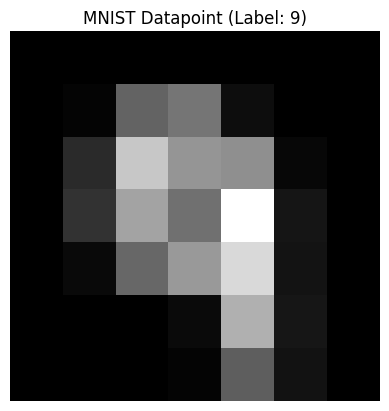

(-0.5, 27.5, 27.5, -0.5)

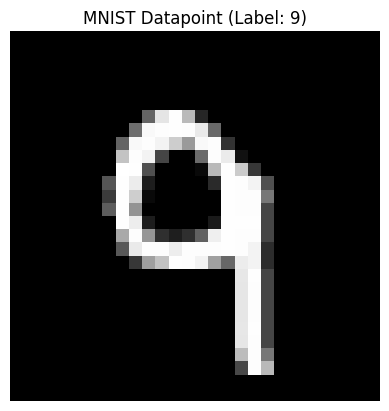

In [3]:
index = 9

image_original = Z_train[index].view(28, 28)
image_downscaled = X_train[index].view(7, 7)
label = y_train[index]

image = image_downscaled.numpy()
image = image * 0.5 + 0.5

plt.imshow(image, cmap='gray')
plt.title(f'MNIST Datapoint (Label: {label})')
plt.axis('off')
plt.show()

image = image_original.numpy()
image = image * 0.5 + 0.5

plt.imshow(image, cmap='gray')
plt.title(f'MNIST Datapoint (Label: {label})')
plt.axis('off')


In [4]:
def softmax(w, t=1.0):
    """
    softmax with max normalization
    """
    max_values, _ = torch.max(w, dim=1, keepdim=True)
    e = torch.exp((w - max_values) / t)
    return e / torch.sum(e, 1).unsqueeze(-1)

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x, temperature=1.0):
        logits = self.fc(x)
        scaled_logits = logits / temperature
        #class_probs = torch.softmax(scaled_logits, dim=1)
        #return F.log_softmax(scaled_logits)
        #return F.softmax(scaled_logits)
        return scaled_logits
        # return self.fc(x)

In [6]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.05
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

teacher_dataset = TensorDataset(Z_train, y_train)
regular_dataset = TensorDataset(X_train, y_train)
regular_test_dataset = TensorDataset(X_test, y_test)
teacher_test_dataset = TensorDataset(Z_test, y_test)
teacher_loader = DataLoader(teacher_dataset, batch_size=batch_size_train, shuffle=True)
regular_loader = DataLoader(regular_dataset, batch_size=batch_size_train, shuffle=True)
regular_test_loader = DataLoader(regular_test_dataset, batch_size=batch_size_test, shuffle=True)
teacher_test_loader = DataLoader(teacher_test_dataset, batch_size=batch_size_test, shuffle=True)

In [7]:
def train(epoch, train_loader):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #  epoch, batch_idx * len(data), len(train_loader.dataset),
      #  100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # torch.save(network.state_dict(), '/results/model.pth')
      # torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [8]:
def test(test_loader):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print(data.shape)
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  accuracy = 100. * correct / len(test_loader.dataset)
  test_accuracies.append(accuracy)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), accuracy))

In [9]:
network = SimpleNet(784, 10)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                     momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_accuracies = []
test_counter = [i*len(regular_loader.dataset) for i in range(n_epochs + 1)]

test(teacher_test_loader)
for epoch in range(1, n_epochs + 1):
  train(epoch, teacher_loader)
  test(teacher_test_loader)

teacher_train_losses = train_losses.copy()
teacher_test_losses = test_losses.copy()
teacher_test_accuracies = test_accuracies.copy()

with torch.no_grad():
  soft_label = F.softmax(network(Z_train)) 
  #soft_label = softmax(network(Z_train), t=.5)

student_dataset = TensorDataset(X_train, soft_label)
student_dataloader = DataLoader(student_dataset, batch_size=batch_size_train, shuffle=True)

c:\users\20204099\appdata\local\programs\python\python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([1000, 784])

Test set: Avg. loss: 2.3053, Accuracy: 1001/10000 (10%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.8262, Accuracy: 7675/10000 (77%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.4682, Accuracy: 8622/10000 (86%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.3893, Accuracy: 8884/10000 (89%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.3636, Accuracy: 8903/10000 (89%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.3237, Accuracy: 9056/10000 (91%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2943, Accuracy: 9131/10000 (91%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2761, Accuracy: 9193/10000 (92%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2746, Accuracy: 9173/10000 (92%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2566, Accuracy: 9251/10000 (93%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2538, Accuracy: 9272/10000 (93%)

torch.Size([1000, 784])

Test set: Avg. loss: 0.2512, Accuracy: 9298/10000 (93%)

torch.Size([1000

C:\Users\20204099\AppData\Local\Temp\ipykernel_16964\876286780.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_label = F.softmax(network(Z_train))


In [10]:
network = SimpleNet(49, 10)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_accuracies = []
test_counter = [i*len(regular_loader.dataset) for i in range(n_epochs + 1)]

test(regular_test_loader)
for epoch in range(1, n_epochs + 1):
  train(epoch, regular_loader)
  test(regular_test_loader)

regular_train_losses = train_losses.copy()
regular_test_losses = test_losses.copy()
regular_test_accuracies = test_accuracies.copy()

torch.Size([1000, 49])

Test set: Avg. loss: 2.3046, Accuracy: 1420/10000 (14%)

torch.Size([1000, 49])

Test set: Avg. loss: 2.2402, Accuracy: 2980/10000 (30%)

torch.Size([1000, 49])

Test set: Avg. loss: 2.0040, Accuracy: 3843/10000 (38%)

torch.Size([1000, 49])

Test set: Avg. loss: 1.4845, Accuracy: 5644/10000 (56%)

torch.Size([1000, 49])

Test set: Avg. loss: 1.0381, Accuracy: 6915/10000 (69%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.8006, Accuracy: 7689/10000 (77%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.6771, Accuracy: 7982/10000 (80%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.5801, Accuracy: 8276/10000 (83%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.5342, Accuracy: 8452/10000 (85%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.4986, Accuracy: 8503/10000 (85%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.4742, Accuracy: 8623/10000 (86%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.4627, Accuracy: 8613/10000 (86%)

torch.Size([1000, 49])

Test

In [11]:
network = SimpleNet(49, 10)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_accuracies = []
test_counter = [i*len(regular_loader.dataset) for i in range(n_epochs + 1)]

test(regular_test_loader)
for epoch in range(1, n_epochs + 1):
  train(epoch, student_dataloader)
  test(regular_test_loader)

student_train_losses = train_losses.copy()
student_test_losses = test_losses.copy()
student_test_accuracies = test_accuracies.copy()

torch.Size([1000, 49])

Test set: Avg. loss: 2.3041, Accuracy: 929/10000 (9%)

torch.Size([1000, 49])

Test set: Avg. loss: 2.2675, Accuracy: 3184/10000 (32%)

torch.Size([1000, 49])

Test set: Avg. loss: 2.1533, Accuracy: 5439/10000 (54%)

torch.Size([1000, 49])

Test set: Avg. loss: 1.6983, Accuracy: 5704/10000 (57%)

torch.Size([1000, 49])

Test set: Avg. loss: 1.0501, Accuracy: 7193/10000 (72%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.8120, Accuracy: 7554/10000 (76%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.6984, Accuracy: 7891/10000 (79%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.6404, Accuracy: 8003/10000 (80%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.5634, Accuracy: 8340/10000 (83%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.5393, Accuracy: 8260/10000 (83%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.5176, Accuracy: 8422/10000 (84%)

torch.Size([1000, 49])

Test set: Avg. loss: 0.4923, Accuracy: 8510/10000 (85%)

torch.Size([1000, 49])

Test s

Text(0, 0.5, 'accuracy')

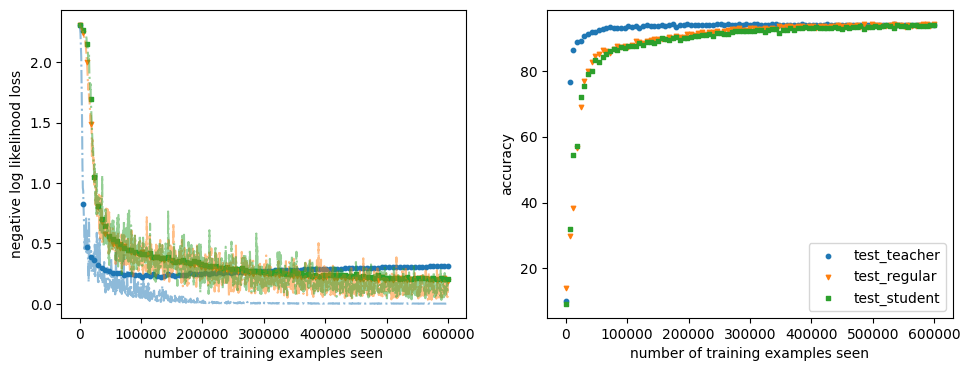

In [12]:
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(11.5, 4))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', 'v', 's']
train_losses = [teacher_train_losses, regular_train_losses, student_train_losses]
test_losses = [teacher_test_losses, regular_test_losses, student_test_losses]
test_accuracies = [teacher_test_accuracies, regular_test_accuracies, student_test_accuracies]
labels = ['teacher', 'regular', 'student']
for i in range(3):
    ax[0].plot(train_counter, train_losses[i], color=colors[i], ls='-.', label='train_' + labels[i], alpha=0.5)
    ax[0].scatter(test_counter, test_losses[i], color=colors[i], marker=markers[i], s=10)
    ax[1].scatter(test_counter, test_accuracies[i], color=colors[i], marker=markers[i], label='test_' + labels[i], s=10)
plt.legend(loc='best')
ax[0].set_xlabel('number of training examples seen')
ax[0].set_ylabel('negative logs likelihood loss')
ax[1].set_xlabel('number of training examples seen')
ax[1].set_ylabel('accuracy')